<a href="https://colab.research.google.com/github/Krish-nobita903/es335-24-fall-assignment-2/blob/master/Task_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns

import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from einops import rearrange

import matplotlib.gridspec as gridspec


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

torch.Size([3, 2401, 3600])


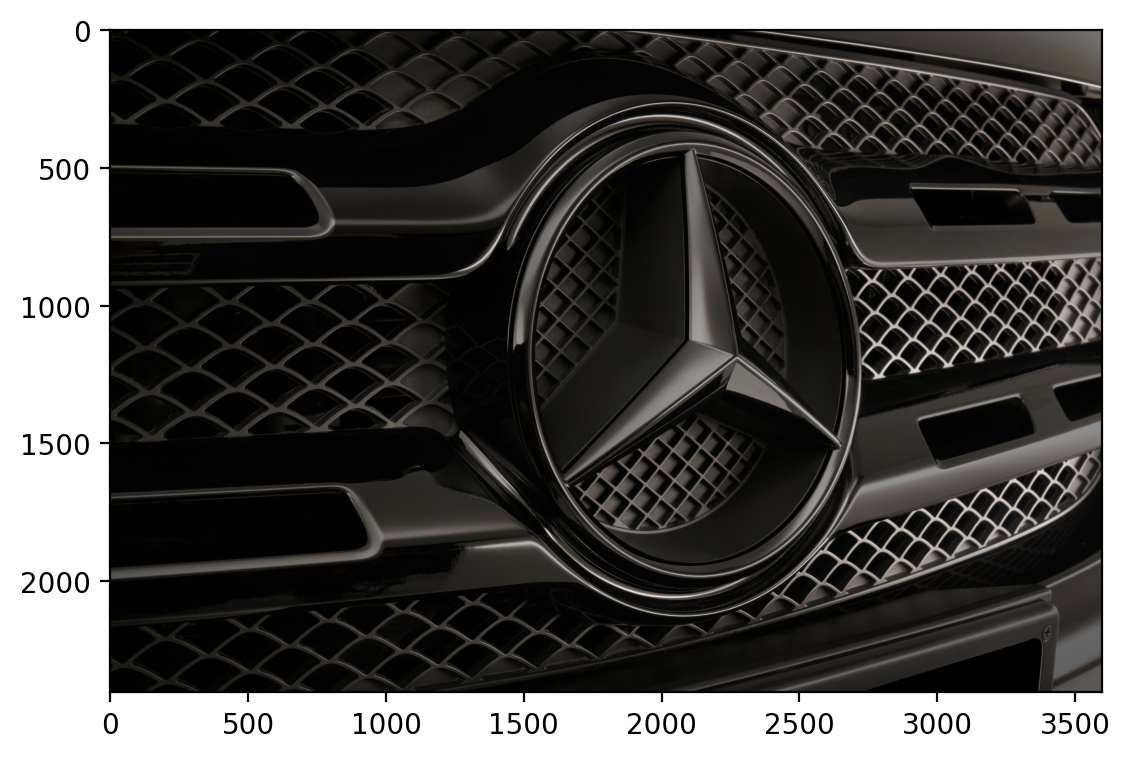

In [2]:
img = torchvision.io.read_image("benz.jpg")
# img = data.astronaut()
print(img.shape)
plt.imshow(img.permute(1, 2, 0))
plt.show()

# Croping to 300x300

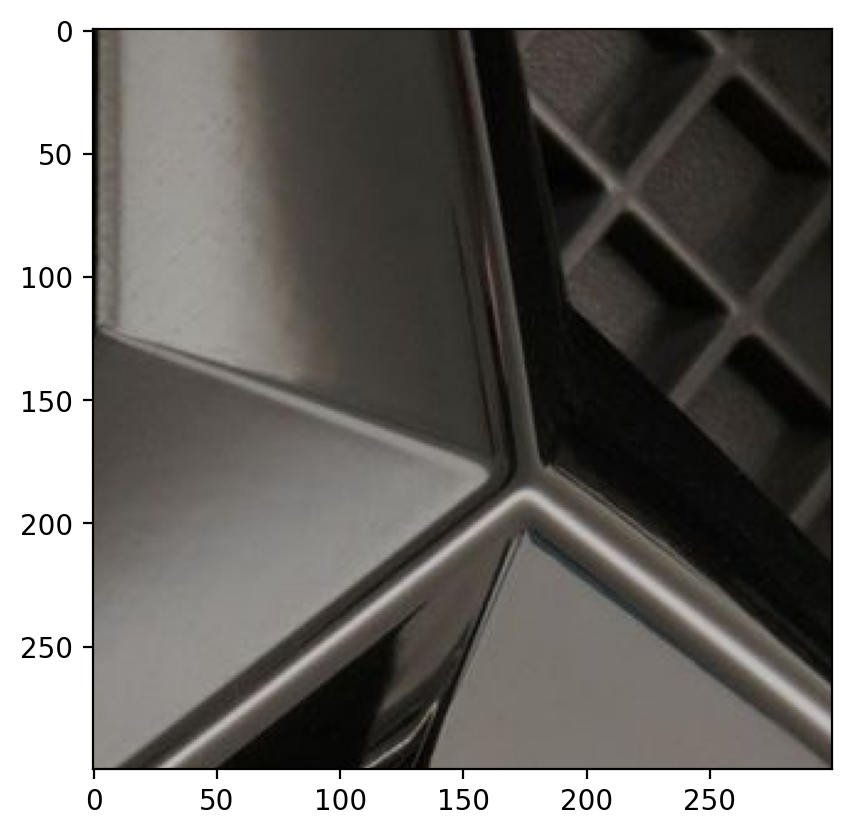

In [3]:
crop = torchvision.transforms.functional.crop(img, 1000, 2100, 300, 300)
plt.imshow(crop.permute(1,2,0))

In [4]:
crop.shape

torch.Size([3, 300, 300])

# Matrix Factorization

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def factorize(A, r, device=torch.device("cpu")):

    A = A.to(device)
    # Randomly initialize W and H
    W = torch.randn(A.shape[0], r, requires_grad=True, device=device)
    H = torch.randn(r, A.shape[1], requires_grad=True, device=device)

    # Optimizer
    optimizer = optim.Adam([W, H], lr=0.01)
    mask = ~torch.isnan(A)
    # Train the model
    for i in range(1000):
        # Compute the loss
        diff_matrix = torch.mm(W,H)-A
        diff_vector = diff_matrix[mask]
        loss = torch.norm(diff_vector)

        # Zero the gradients
        optimizer.zero_grad()

        # Backpropagate
        loss.backward()

        # Update the parameters
        optimizer.step()

    return W, H, loss

# Predict images for different rank

Rank is 50
Losses  are (R,G,B) = (1070.7847900390625,1070.2540283203125,1051.325927734375) 
loss sum: (tensor(2141.0388, grad_fn=<AddBackward0>), tensor(1051.3259, grad_fn=<LinalgVectorNormBackward0>))


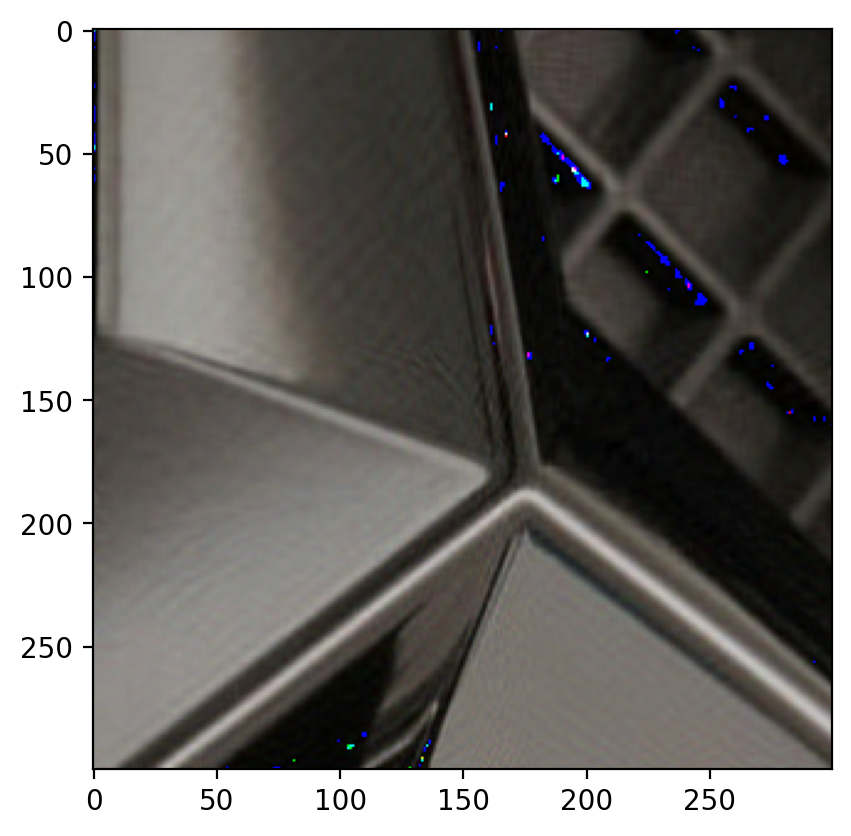

Rank is 150
Losses  are (R,G,B) = (142.87600708007812,147.84530639648438,140.58663940429688) 
loss sum: (tensor(290.7213, grad_fn=<AddBackward0>), tensor(140.5866, grad_fn=<LinalgVectorNormBackward0>))


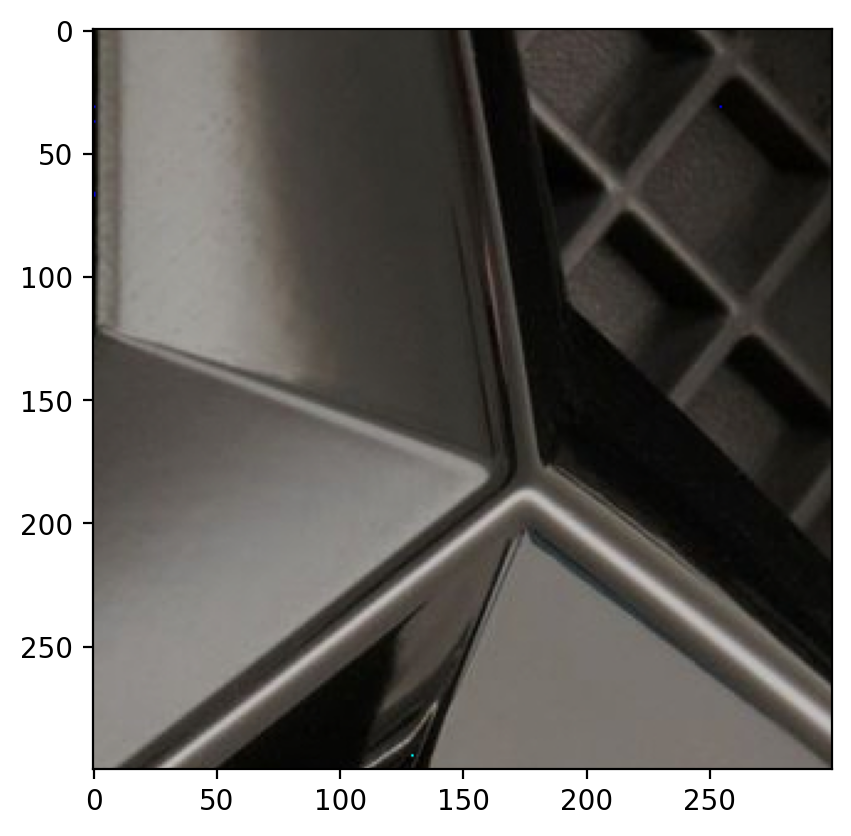

Rank is 250
Losses  are (R,G,B) = (57.94277572631836,57.097713470458984,55.85953140258789) 
loss sum: (tensor(115.0405, grad_fn=<AddBackward0>), tensor(55.8595, grad_fn=<LinalgVectorNormBackward0>))


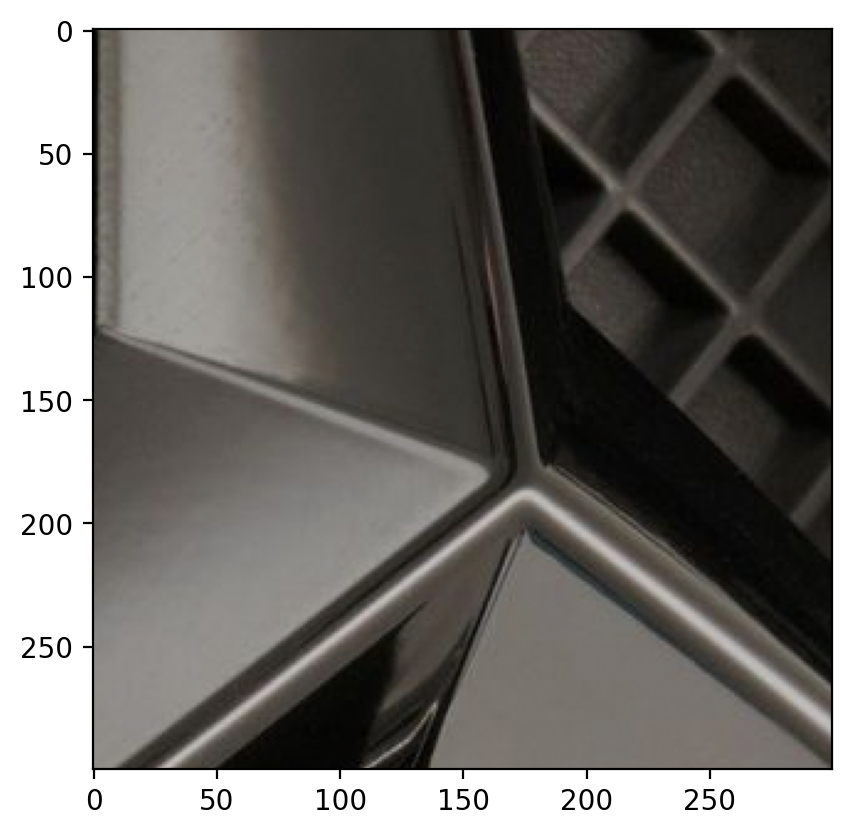

In [6]:

for rank in range(50,300,100):
    # rank = 50
    R = crop[0, :, :]  # Red channel
    G = crop[1, :, :]  # Green channel
    B = crop[2, :, :]  # Blue channel

    U_R, V_R, loss_R = factorize(R, rank)
    U_G, V_G, loss_G = factorize(G, rank)
    U_B, V_B, loss_B = factorize(B, rank)

    # Reconstruct the channels
    R_reconst = np.dot(U_R.detach().numpy(), V_R.detach().numpy())
    G_reconst = np.dot(U_G.detach().numpy(), V_G.detach().numpy())
    B_reconst = np.dot(U_B.detach().numpy(), V_B.detach().numpy())

    # Stack the channels back into a color image
    img_reconst = np.stack([R_reconst, G_reconst, B_reconst], axis=2).astype(np.uint8)
    # img_reconst = torch.tensor(img_reconst, dtype=torch.uint8)


    # img_reconst= [R_reconst, G_reconst, B_reconst]
    print(f"Rank is {rank}")
    print(f"Losses  are (R,G,B) = ({loss_R},{loss_G},{loss_B}) ")
    print(f"loss sum: {loss_R + loss_G, loss_B}")
    plt.imshow(img_reconst)
    plt.show()


Rank is 250
Losses  are (R,G,B) = (57.94277572631836,57.097713470458984,55.85953140258789) 
loss sum: (tensor(115.0405, grad_fn=<AddBackward0>), tensor(55.8595, grad_fn=<LinalgVectorNormBackward0>))


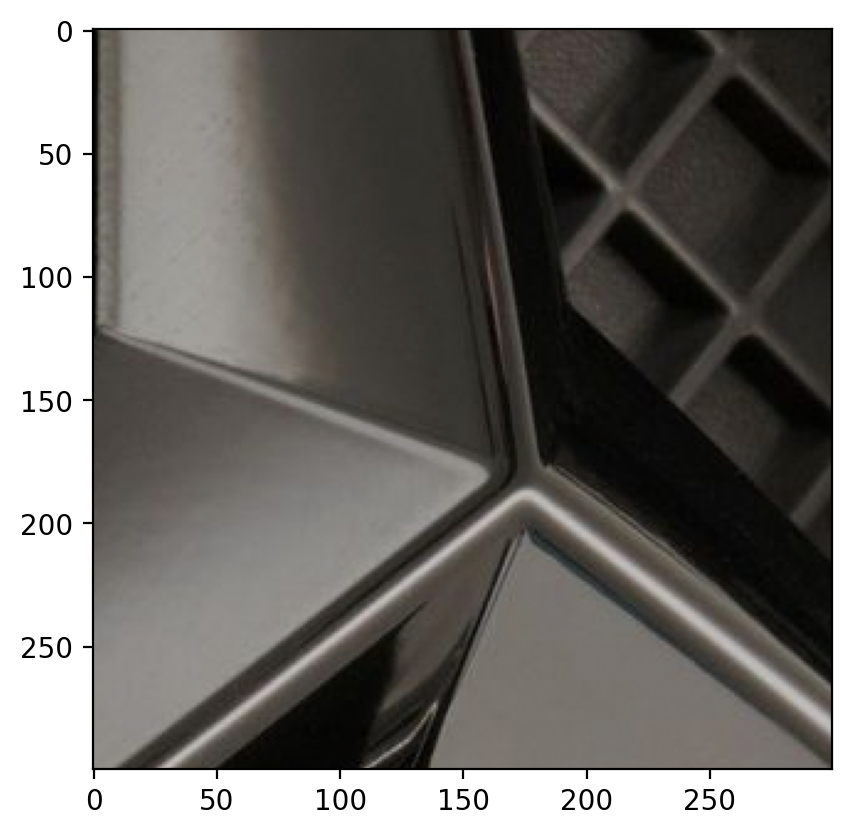

In [7]:
print(f"Rank is {rank}")
print(f"Losses  are (R,G,B) = ({loss_R},{loss_G},{loss_B}) ")
print(f"loss sum: {loss_R + loss_G, loss_B}")
plt.imshow(img_reconst)
plt.show()

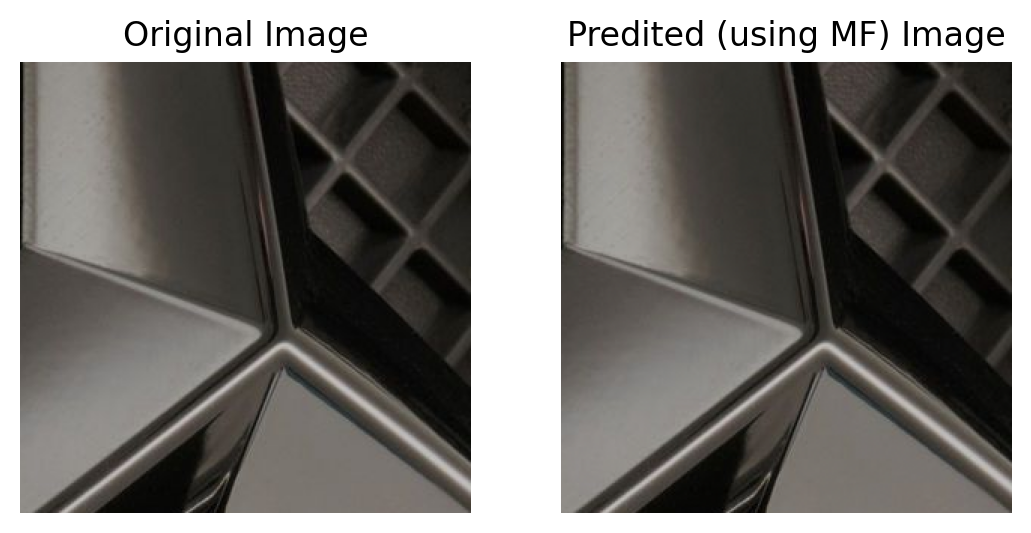

In [8]:
# pred_img = torch.mm(W,H).cpu().detach().numpy()
# plt.figure(figsize=(100,300))
plt.subplot(1,2,1)
plt.imshow(crop.permute(1,2,0))
plt.title("Original Image")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(img_reconst)
plt.title("Predited (using MF) Image")
plt.axis("off")
plt.show()


# Function for finding the PSNR and RMSE error

In [9]:
def rmse_psnr(org, pred):
    if isinstance(org, np.ndarray):
        org = torch.from_numpy(org)
    if isinstance(pred, np.ndarray):
        pred = torch.from_numpy(pred)
    squared_diff = (org.float() - pred.float()) ** 2

    mse = torch.mean(squared_diff)
    rmse = torch.sqrt(mse)

    max_pixel_value = 255.0

    psnr = 20 * np.log10(max_pixel_value / rmse)

    return rmse, psnr


In [10]:
rmse,psnr = rmse_psnr(crop.permute(1,2,0),img_reconst)

In [11]:
print(f"rmse: {rmse} , psnr: {psnr}")

rmse: 0.5149074196815491 , psnr: 53.89622116088867


# Question 2

In [12]:
img2 = torchvision.io.read_image("benz.jpg")
print(img2.shape)

torch.Size([3, 2401, 3600])


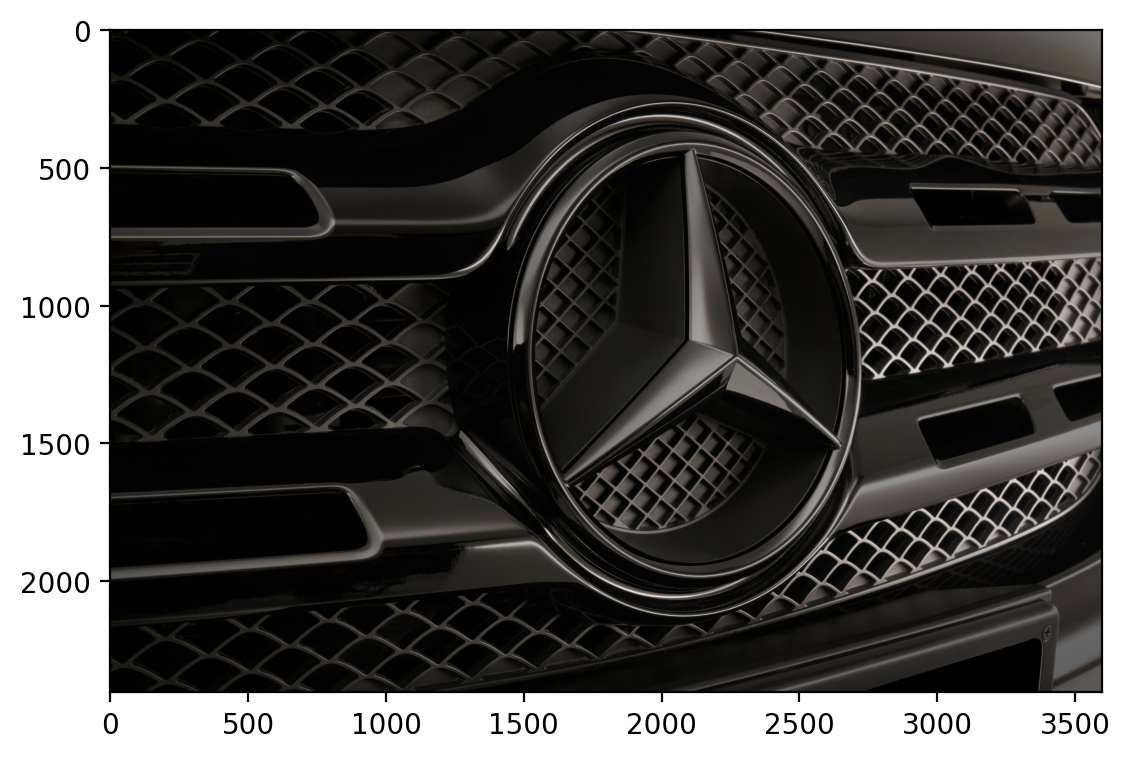

In [13]:
plt.imshow(img2.permute(1,2,0))

# Changing the dimension

torch.Size([3, 300, 300])

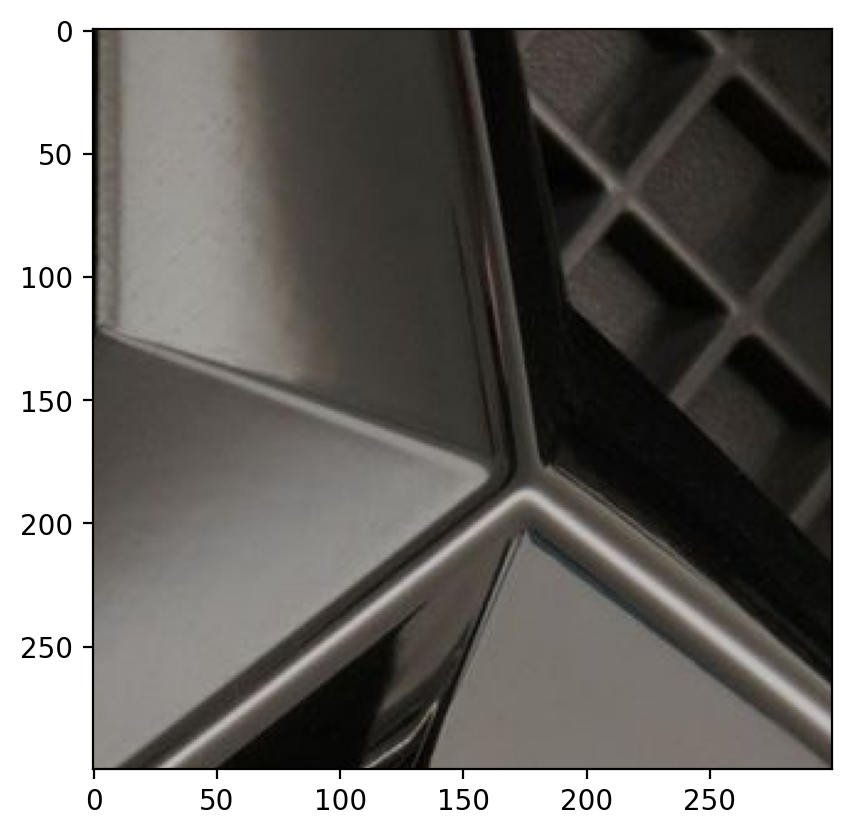

In [14]:
c_img = torchvision.transforms.functional.crop(img2, 1000, 2100, 300, 300)
plt.imshow(c_img.permute(1,2,0))
c_img.shape

In [15]:
c_img.permute(1,2,0).shape

torch.Size([300, 300, 3])

/usr/local/lib/python3.10/dist-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


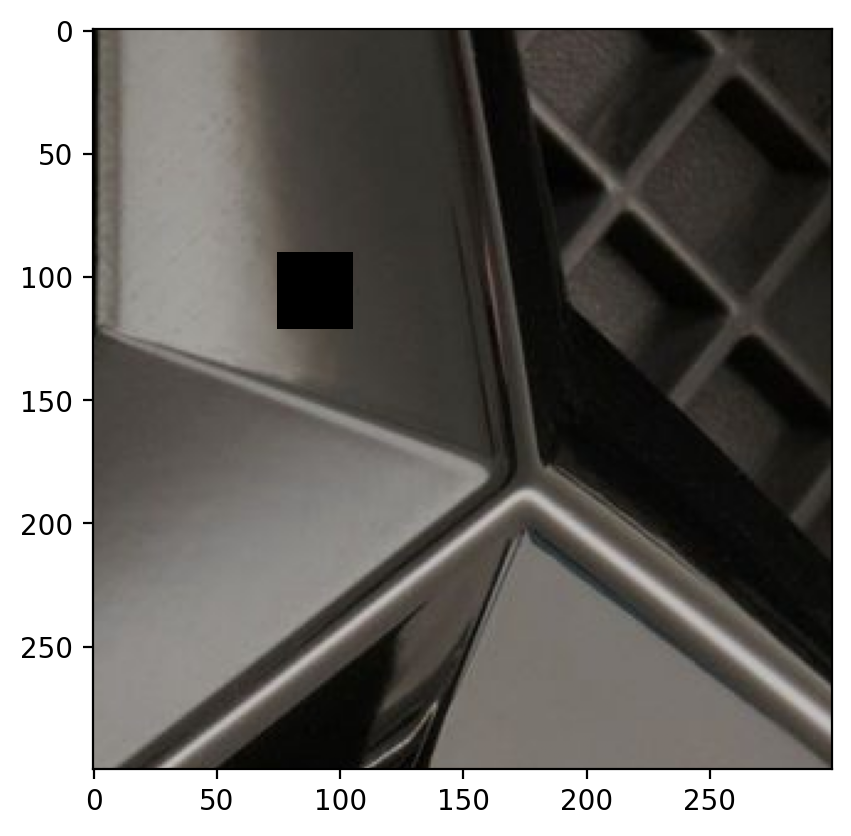

In [16]:
import torch
import matplotlib.pyplot as plt

def img_pix_rm(i_img, block_size, num_blocks):
    img = i_img.clone().float()
    _, height, width = img.shape

    # Ensure block size fits within the image dimensions
    block_size = min(block_size, min(height, width))

    for _ in range(num_blocks):
        # Randomly select the top-left corner of the block
        top_left_x = torch.randint(0, height - block_size + 1, (1,))
        top_left_y = torch.randint(0, width - block_size + 1, (1,))

        # Set the pixels within the block to NaN
        for channel in range(3):
            img[channel, top_left_x:top_left_x + block_size, top_left_y:top_left_y + block_size] = float('nan')

    return img

# Example usage
block_size = 30
num_blocks = 1  # You can increase the number of blocks if you want to remove more than one block
m_img = img_pix_rm(c_img, block_size, num_blocks)

# Display the modified image
plt.imshow(m_img.permute(1, 2, 0).cpu().numpy() / 255)
plt.show()


#Using Matrix Factorisatoin

Rank is 50
Losses  are (R,G,B) = (1053.3564453125,1047.4278564453125,1042.0478515625) 
loss sum: (tensor(2100.7842, grad_fn=<AddBackward0>), tensor(1042.0479, grad_fn=<LinalgVectorNormBackward0>))


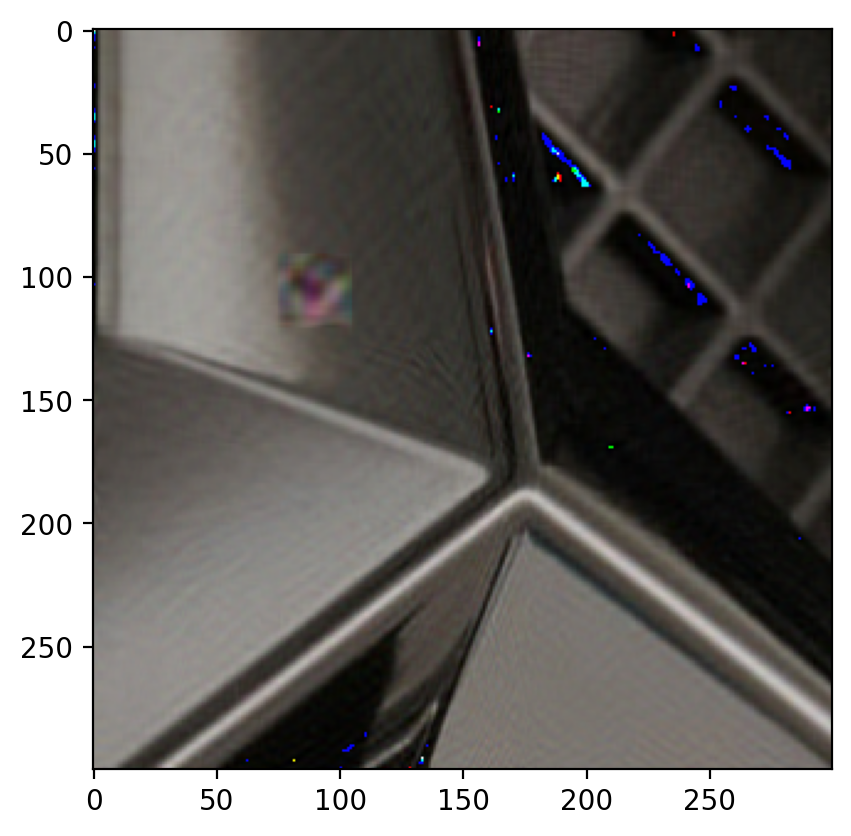

Rank is 150
Losses  are (R,G,B) = (146.91632080078125,137.7639923095703,138.01919555664062) 
loss sum: (tensor(284.6803, grad_fn=<AddBackward0>), tensor(138.0192, grad_fn=<LinalgVectorNormBackward0>))


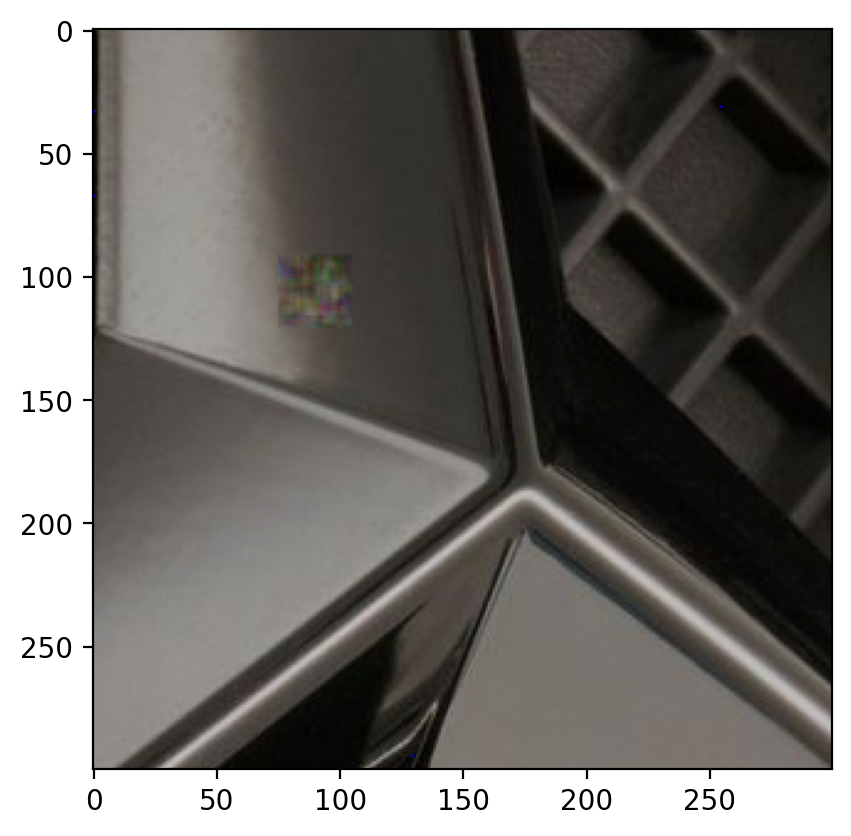

Rank is 250
Losses  are (R,G,B) = (56.47843551635742,54.214759826660156,52.980796813964844) 
loss sum: (tensor(110.6932, grad_fn=<AddBackward0>), tensor(52.9808, grad_fn=<LinalgVectorNormBackward0>))


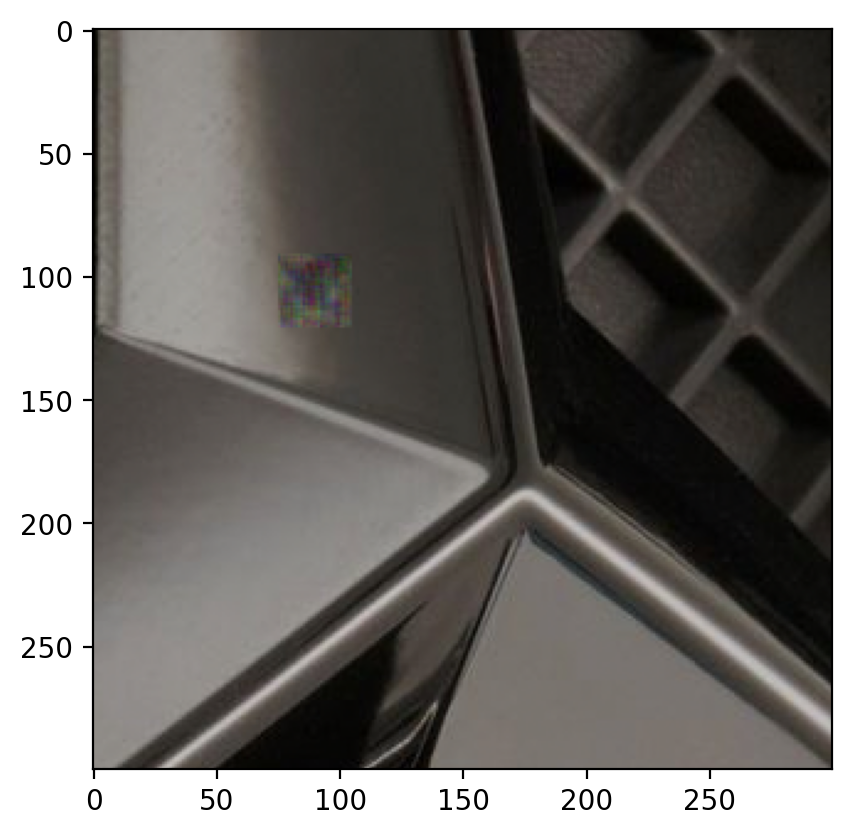

In [17]:
for rank in range(50,300,100):
# rank = 50
    R = m_img[0, :, :]
    G = m_img[1, :, :]
    B = m_img[2, :, :]

    U_R, V_R, loss_R = factorize(R, rank)
    U_G, V_G, loss_G = factorize(G, rank)
    U_B, V_B, loss_B = factorize(B, rank)

    R_rc = np.dot(U_R.detach().numpy(), V_R.detach().numpy())
    G_rc = np.dot(U_G.detach().numpy(), V_G.detach().numpy())
    B_rc = np.dot(U_B.detach().numpy(), V_B.detach().numpy())

    img_rc = np.stack([R_rc, G_rc, B_rc], axis=2).astype(np.uint8)
    print(f"Rank is {rank}")
    print(f"Losses  are (R,G,B) = ({loss_R},{loss_G},{loss_B}) ")
    print(f"loss sum: {loss_R + loss_G, loss_B}")
    plt.imshow(img_rc)
    plt.show()

In [18]:
rmse,psnr = rmse_psnr(c_img.permute(1,2,0),img_rc)


# RMSE PSNR

In [19]:
print(f"Rank is {rank}")
print(f"Losses  are (R,G,B) = ({loss_R},{loss_G},{loss_B}) ")
print(f"loss sum: {loss_R + loss_G, loss_B}")
print(f"rmse is {rmse}, psnr is {psnr}")

Rank is 250
Losses  are (R,G,B) = (56.47843551635742,54.214759826660156,52.980796813964844) 
loss sum: (tensor(110.6932, grad_fn=<AddBackward0>), tensor(52.9808, grad_fn=<LinalgVectorNormBackward0>))
rmse is 1.7730764150619507, psnr is 43.15625762939453


In [20]:
torch.sum(torch.isnan(m_img)).item()

2700

# Using RFF

In [21]:
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.kernel_approximation import RBFSampler

In [22]:
def rff_reconstruction(corrupted_image):
    x_train = []
    y_train = []
    for i in range(corrupted_image.shape[0]):
        for j in range(corrupted_image.shape[1]):
            if not np.isnan(corrupted_image[i, j]):
                x_train.append([i, j])
                y_train.append(corrupted_image[i, j])

    x_train = np.array(x_train)
    y_train = np.array(y_train)

    rbf_sampler = RBFSampler(gamma=1.0, n_components=10000)
    X_features = rbf_sampler.fit_transform(x_train, y_train)

    reg = LinearRegression().fit(X_features, y_train)

    x_test = [[i, j] for i in range(corrupted_image.shape[0]) for j in range(corrupted_image.shape[0])]
    X_test_features = rbf_sampler.transform(x_test)
    y_pred = reg.predict(X_test_features)

    reconstructed_image_rff = corrupted_image.clone()
    for idx, (i, j) in enumerate(x_test):
        # if np.isnan(reconstructed_image_rff[i, j]):
        reconstructed_image_rff[i, j] = y_pred[idx]

    return reconstructed_image_rff

In [23]:
rff_r = rff_reconstruction(m_img[0])
rff_g = rff_reconstruction(m_img[1])
rff_b = rff_reconstruction(m_img[2])

In [24]:
pred_img_rff = np.stack([rff_r, rff_g, rff_b], axis=2).astype(np.uint8)

Text(0.5, 1.0, 'RFF predicted Image')

/usr/local/lib/python3.10/dist-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


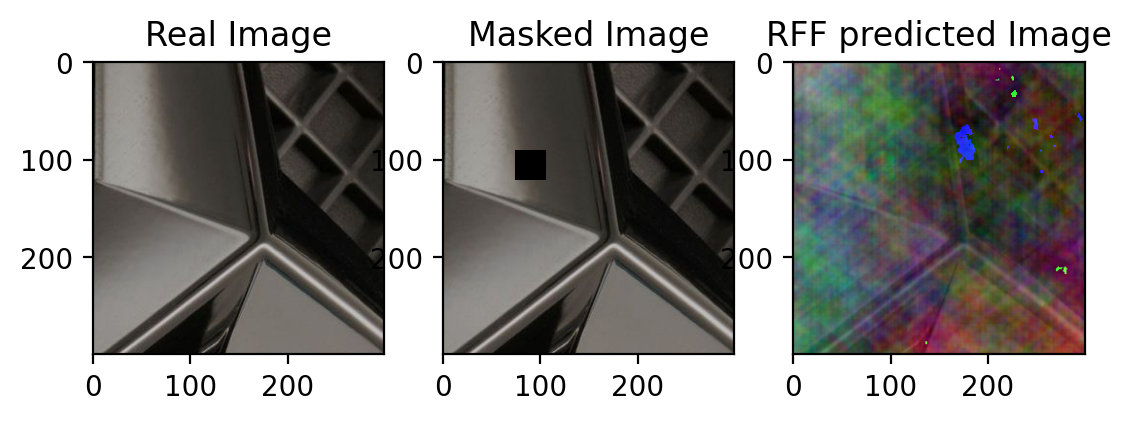

In [25]:
plt.tight_layout()

plt.subplot(1,3,1)
plt.imshow(c_img.permute(1,2,0))
plt.title("Real Image")
plt.subplot(1,3,2)
plt.imshow(m_img.permute(1, 2, 0).cpu().numpy() / 255)
plt.title("Masked Image")
plt.subplot(1,3,3)
plt.imshow(pred_img_rff)
plt.title("RFF predicted Image")

In [26]:
rmse_rff,psnr_rff = rmse_psnr(c_img.permute(1, 2, 0),pred_img_rff)
rmse_mf,psnr_mf = rmse_psnr(c_img.permute(1,2,0),img_rc)

In [26]:
plt.tight_layout()

plt.subplot(1,3,1)
plt.imshow(c_img.permute(1, 2, 0),cmap='gray')
plt.title("Original Image")
plt.subplot(1,3,2)
plt.imshow(img_rc)
plt.title("Matrix Facto. Image")
plt.subplot(1,3,3)
plt.imshow(pred_img_rff)
plt.title("RFF predict Image")

In [27]:
print("For RFF")
print(f"rmse: {rmse_rff} , psnr: {psnr_rff}")
print("For Matrix Factorisation")
print(f"rmse: {rmse_mf} , psnr: {psnr_mf}")


For RFF
rmse: 38.50672912597656 , psnr: 16.42007064819336
For Matrix Factorisation
rmse: 1.7730764150619507 , psnr: 43.15625762939453


We can see that the Prediction using Matrix Factorisation is better than by using Random Fourier Features (RFF) and Linear Regression.
<br>
RMSE(Matrix Factorisation) < RMSE(RFF and Linear Regression)
<br>
PSNR(Matrix Factorisation) > PSNR(RFF and Linear Regression)